In [1]:
import torch
import numpy as np
import pandas as pd
from models_A import preprocessing_from_matlab
from scipy.io.matlab import loadmat
from matplotlib import pyplot as plt
from sklearn.preprocessing import normalize
from models_A import ModelA, ModelAN
from seaborn import set_theme

set_theme(style="dark", 
          palette="colorblind",
          rc={"text.usetex": True,
              "font.family": "sans-serif",
              "text.latex.preamble": r"\usepackage{sfmath}",
              "lines.linewidth": 1,
              "axes.facecolor": "f2f2f2"})
%matplotlib widget

In [2]:
states_mat = loadmat("../../../../xs_all_new.mat")
forces_mat = loadmat("../../../../tau_all_new.mat")

In [3]:
random_force_denorm = forces_mat["tau_all"][0][900].T
pd.DataFrame(random_force_denorm)

,0,1,2,3
0,21.582000,0.000000,0.000000,0.000000e+00
1,28.842000,0.000000,0.000000,-2.500000e-01
2,28.842000,-0.004980,0.205739,-2.500000e-01
3,28.812944,-0.004904,0.199957,-2.489069e-01
4,28.783856,-0.005144,0.177539,-2.477922e-01
...,...,...,...,...
19996,21.584045,-0.000659,-0.001657,-6.044427e-07
19997,21.584045,-0.000389,-0.001898,-6.060750e-07
19998,21.584045,0.000329,-0.004120,-6.183297e-07
19999,21.584045,0.000173,0.002009,-6.232567e-07


In [4]:
states, states_norms = preprocessing_from_matlab(states_mat)
forces, forces_norms = preprocessing_from_matlab(forces_mat)

In [5]:
random_state, random_state_norm = states[900], states_norms[900]
random_force, random_force_norm = forces[900], forces_norms[900]

In [6]:
model = ModelA()
model.load_state_dict(torch.load("model.pt"))
model_norms = ModelAN()
model_norms.load_state_dict(torch.load("model_norms.pt"))

<All keys matched successfully>

In [7]:
model.eval()
with torch.inference_mode():
    normalized_forces = model(torch.tensor(random_state, dtype=torch.float32))

In [8]:
model_norms.eval()
with torch.inference_mode():
    forces_norms = model_norms(torch.tensor(random_state_norm, dtype=torch.float32))

In [9]:
forces = []
for i in range(normalized_forces.shape[-1]):
    force_denorm = normalized_forces[:,i]*forces_norms[i]
    force_denorm = force_denorm.numpy()
    forces.append(force_denorm)
forces = np.array(forces).T

In [10]:
pd.DataFrame(forces).T.to_csv("forces_complete.csv", index=False, header=False)

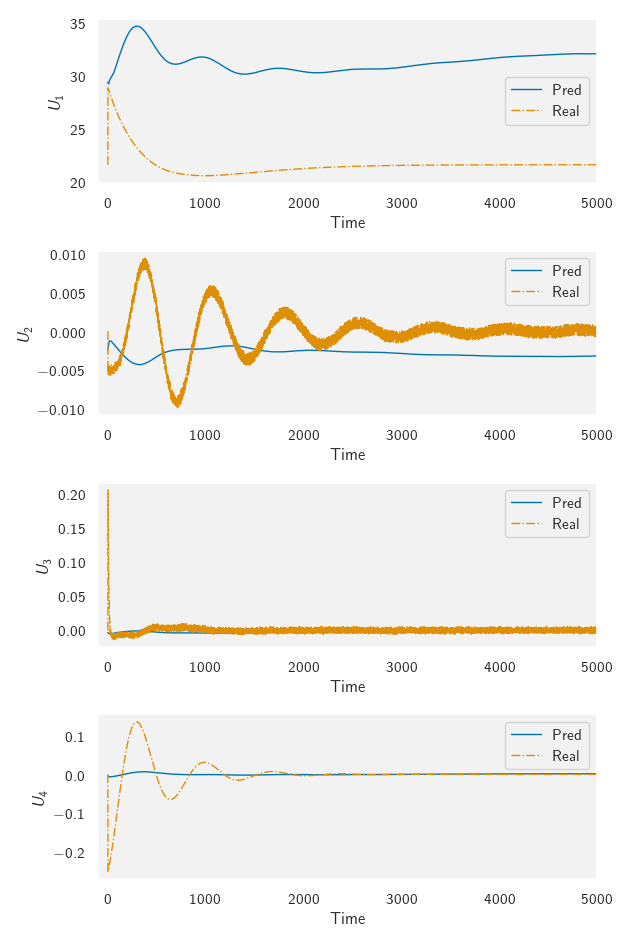

In [11]:
t = np.linspace(0,20000,20001)

cm=1/2.54
fig, axs = plt.subplots(4,1, figsize=(16*cm,24*cm))
for i, ax in enumerate(axs.flatten()):
    # if i == 2:
    #     x1, x2, y1, y2 = 0, 2000, -0.05, 0.05  # subregion of the original image
    #     axins = ax.inset_axes([0.25, 0.25, 0.7, 0.47],xlim=(x1, x2), ylim=(y1,y2), xticklabels=[], yticklabels=[])
    #     axins.plot(t, forces[:,i]+correction[i])
    #     axins.plot(t, random_force_denorm[:,i])
    #     ax.indicate_inset_zoom(axins, edgecolor="black")
    ax.set_xlim(-100,5000)
    ax.plot(t, forces[:,i], label="Pred")
    ax.plot(t, random_force_denorm[:,i], label="Real", ls="-.")
    ax.set_xlabel("Time")
    ax.set_ylabel(f"$U_{i+1}$")
    # ax.ticklabel_format(style="sci",
    #                     scilimits=(0,0),
    #                     useMathText=True,
    #                     axis="x")
    ax.legend()

fig.tight_layout()
fig.savefig("../../../report/figures/4results/uav/forces_denormalized.pdf")

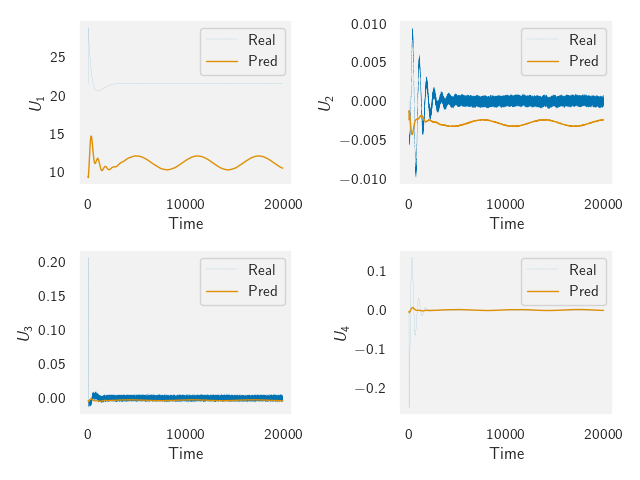

In [12]:
cm=1/2.54
# fig, axs = plt.subplots(4,1, figsize=(16*cm,24.7*cm))
fig, axs = plt.subplots(2,2, gridspec_kw={'width_ratios': [2, 2]})
                        
                        
correction = [-20, 0, 0, 0]

for i, ax in enumerate(axs.flatten()):
    ax.plot(t, random_force_denorm[:,i], label="Real", ls="-.", lw=0.1)
    ax.plot(t, forces[:,i]+correction[i], label="Pred")
    
    ax.set_xlabel("Time")
    ax.set_ylabel(f"$U_{i+1}$")
    # ax.ticklabel_format(style="sci",
    #                     scilimits=(0,0),
    #                     useMathText=True,
    #                     axis="x")
    ax.legend()
    # if i == 1:
    #     x1, x2, y1, y2 = 1000, 3000, -0.02, 0.02  # subregion of the original image
    #     axins = ax.inset_axes([0.25, 0.25, 0.7, 0.47],xlim=(x1, x2), ylim=(y1,y2), xticklabels=[], yticklabels=[])
    #     axins.plot(t, forces[:,i]+correction[i])
    #     axins.plot(t, random_force_denorm[:,i])
    #     ax.indicate_inset_zoom(axins, edgecolor="black")
    # if i == 2:
    #     x1, x2, y1, y2 = 0, 2000, -0.05, 0.05  # subregion of the original image
    #     axins = ax.inset_axes([0.25, 0.25, 0.7, 0.47],xlim=(x1, x2), ylim=(y1,y2), xticklabels=[], yticklabels=[])
    #     axins.plot(t, forces[:,i]+correction[i])
    #     axins.plot(t, random_force_denorm[:,i])
    #     ax.indicate_inset_zoom(axins, edgecolor="black")
    

fig.tight_layout()
fig.savefig("../../../report/figures/4results/uav/forces_denormalized_correction.pdf")